Tutorial assumes some basic knowledge of neural networks.  If you’re not, you can learn the basics of neural networks and PyTorch at [course.fast.ai](https://course.fast.ai/). 

* Tutorial materials is derived from [_What is torch.nn really?_](https://pytorch.org/tutorials/beginner/nn_tutorial.html) by Jeremy Howard, Rachel Thomas, Francisco Ingham.


In [3]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import model_selection, preprocessing
import torch

In [4]:
%matplotlib inline

# Getting the MNIST data

## Download the data from Kaggle...

### 1. Register for an account with Kaggle

In order to download Kaggle competition data you will first need to create a [Kaggle](https://www.kaggle.com/) account.

### 2. Create an API key

Once you have registered for a Kaggle account you will need to create some [API credentials](https://github.com/Kaggle/kaggle-api#api-credentials) in order to be able to use the `kaggle` CLI to download data.

### 3. Download the Data

Execute the code in the following cell to download the Kaggle [Digit Recognizer: Learn computer vision with the famous MNIST data](https://www.kaggle.com/c/digit-recognizer) competition data. In order for the following Kaggle API call to work you will need to login to your Kaggle account and accept the rules for this competition.

In [ ]:
%%bash
export KAGGLE_USERNAME="YOUR_USERNAME"
export KAGGLE_KEY="YOUR_API_KEY"
kaggle competitions download -c digit-recognizer -p ../data/raw/mnist/

## ...or not!

If you don't want to set up an account with Kaggle, then no worries! I have included the training and testing data sets for you.

    ../data/raw/mnist/train.csv
    ../data/raw/mnist/test/csv
    

# Load the MNIST data

In [5]:
!head ../data/raw/mnist/train.csv

label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel1

In [45]:
mnist_arr = np.loadtxt("../data/raw/mnist/train.csv", delimiter=',', skiprows=1, dtype=np.int64)

In [46]:
# raw features are between 0 and 255
mnist_arr.min(), mnist_arr.max()

(0, 255)

## Split the MNIST data into training and validation sets

Since Kaggle has already split the MNIST data set into training and testing data sets, we only need to split our training data set into training and validation data. We will use the validation data to make sure that we are not over-fitting our models.

In [47]:
prng = np.random.RandomState(42)
training_arr, validation_arr = model_selection.train_test_split(mnist_arr, test_size=0.20, random_state=prng)

In [48]:
training_arr.shape

(33600, 785)

In [49]:
training_target, training_features = training_arr[:, 0], training_arr[:, 1:]

In [50]:
validation_arr.shape

(8400, 785)

In [51]:
validation_target, validation_features = validation_arr[:, 0], validation_arr[:, 1:]

## Rescale the raw data

Data for individual pixels is stored as integers between 0 and 255. Neural network models work best when numerical features are scaled. To rescale the raw features we can use tools from the [Scikit-Learn preprocessing module](https://scikit-learn.org/stable/modules/preprocessing.html).

In [52]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled_training_features = min_max_scaler.fit_transform(training_features)
scaled_validation_features = min_max_scaler.fit_transform(validation_features)

/Users/pughdr/miniconda3/envs/pytorch-gpu-tutorial/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/pughdr/miniconda3/envs/pytorch-gpu-tutorial/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


## Check out a training sample

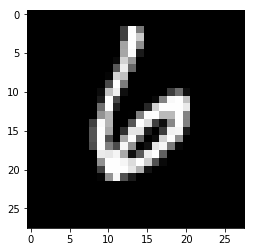

In [53]:
_, ax = plt.subplots(1,1)
_ = ax.imshow(scaled_training_features[0].reshape((28, 28)), cmap="gray")

PyTorch uses `torch.tensor` rather than `numpy.ndarray` so we need to convert data.

In [54]:
training_target = torch.tensor(training_target)
scaled_training_features = torch.tensor(scaled_training_features, dtype=torch.float32)

validation_target = torch.tensor(validation_target)
scaled_validation_features = torch.tensor(scaled_validation_features, dtype=torch.float32)

In [55]:
scaled_training_features

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [56]:
scaled_training_features.max()

tensor(1.)

In [57]:
scaled_training_features.dtype

torch.float32

In [58]:
training_target

tensor([6, 5, 3,  ..., 2, 6, 0])

# Neural network from scratch

First let's create a simple model using nothing but [PyTorch tensor operations](https://pytorch.org/docs/stable/tensors.html). PyTorch provides methods to create random or zero-filled tensors, which we will use to create our weights and bias for a simple linear model. These are just regular tensors, with one very special addition: we tell PyTorch that they require a gradient. This causes PyTorch to record all of the operations done on the tensor, so that it can calculate the gradient during back-propagation automatically!

For the weights, we set `requires_grad` after the initialization, since we don’t want that step included in the gradient. (Note that a trailling `_` in PyTorch signifies that the operation is performed _in-place_.)

In [96]:
number_samples, number_features = scaled_training_features.shape

# using Xavier initialization (divide weights by sqrt(number_features))
weights = torch.randn(number_features, 10) / number_features**0.5
weights.requires_grad_() # trailing underscore indicates in-place operation
bias = torch.zeros(10, requires_grad=True)

Thanks to PyTorch’s ability to calculate gradients automatically, we can use any standard Python function (or callable object) in a model! So we will start by writing a function to peform matrix multiplication and broadcasted addition called `_linear_transformation`. We will also need an activation function, so we’ll write a function called `_log_softmax_activation` and use it. 

**N.B.** Although PyTorch provides lots of pre-written loss functions, activation functions, and so forth, you can easily write your own using plain python. PyTorch will even create fast GPU or vectorized CPU code for your function automatically.

In [97]:
def _linear_transformation(X):
    return X @ weights + bias

def _log_softmax_activation(X):
    return X - X.exp().sum(-1).log().unsqueeze(-1)
    
def model(X):
    Z = _linear_transformation(X)
    return _log_softmax_activation(Z)

In the above, the `@` stands for the dot product operation. We will call our function on one batch of data (in this case, 64 images). Note that our predictions won’t be any better than random at this stage, since we start with random weights.

In [98]:
batch_size = 64
output = model(scaled_training_features[:batch_size])

In [99]:
output[1]

tensor([-1.9265, -2.3154, -1.9657, -2.6860, -2.3570, -2.5095, -2.5739, -2.3687,
        -2.0329, -2.6507], grad_fn=<SelectBackward>)

As you see, the `output` tensor contains not only the tensor values, but also a gradient function, `grad_fn`. We’ll use this later to do back propagation to update the model parameters.

Let’s implement `negative_log_likelihood` to use as the loss function. Again, we can just use standard Python code.

In [100]:
def negative_log_likelihood(output, target):
    m, _ = output.shape
    return -output[range(m), target].mean()
    

In [101]:
negative_log_likelihood(output, training_target[:batch_size])

tensor(2.4215, grad_fn=<NegBackward>)

Let’s also implement a function to calculate the `accuracy` of our model: for each prediction, if the index with the largest value matches the target value, then the prediction was correct.

In [102]:
def accuracy(output, target):
    predictions = torch.argmax(output, dim=1)
    return (predictions == target).float().mean()

For comparison purposes we can compute the accuracy of our model with randomly initialized parameters.

In [104]:
accuracy(output, training_target[:batch_size])

tensor(0.0625)

We can now run a training loop. For each iteration, we will:

* select a mini-batch of data (of size bs)
* use the model to make predictions
* calculate the loss
* `loss.backward()` updates the gradients of the model.

We now use these gradients to update the weights and bias (i.e., model parameters). We do this within the `torch.no_grad()` context manager, because we do not want these actions to be recorded for our next calculation of the gradient. You can read more about how PyTorch’s Autograd records operations [here](https://pytorch.org/docs/stable/notes/autograd.html).

We then set the gradients to zero, so that we are ready for the next loop. Otherwise, our gradients would record a running tally of all the operations that had happened (i.e. loss.backward() adds the gradients to whatever is already stored, rather than replacing them).

In [105]:
number_epochs = 2
number_batches = (number_samples - 1) // batch_size + 1

learning_rate = 0.5
for epoch in range(number_epochs):
    for batch in range(number_batches):
        
        # forward pass
        start = batch * batch_size
        X = scaled_training_features[start:(start + batch_size)]
        y = training_target[start:(start + batch_size)]
        output = model(X)
        loss = negative_log_likelihood(output, y)
        
        # back propagation
        loss.backward()
        with torch.no_grad():
            weights -= learning_rate * weights.grad
            bias -= learning_rate * bias.grad
            weights.grad.zero_()
            bias.grad.zero_()
            

That’s it: we’ve created and trained a minimal neural network (in this case, a logistic regression, since we have no hidden layers) entirely from scratch! Let’s check the loss and accuracy and compare those to what we got earlier. We expect that the loss will have decreased and accuracy to have increased, and they have.

In [106]:
negative_log_likelihood(model(X), y), accuracy(model(X), y)

(tensor(0.0943, grad_fn=<NegBackward>), tensor(0.9844))

# Refactor using `torch.nn.functional`

In [ ]:
import torch.nn.functional as F

In [ ]:
def model(X):
    return X @ weights + bias

loss_function = F.cross_entropy

In [ ]:
loss_function(model(X), y), accuracy(model(X), y)

# Refactor using `torch.nn.Module`

In [ ]:
from torch import nn


class MNISTLogisticRegression(nn.Module):
    
    def __init__(self):
        super().__init__()
        self._weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self._bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, X):
        return X @ self._weights + self._bias
    


In [ ]:
model = MNISTLogisticRegression()

In [ ]:
loss_function(model(X), y)

In [ ]:
def fit(model, loss_function, number_samples, number_epochs=2, batch_size=64):
    
    number_batches = (number_samples - 1) // batch_size + 1
    for epoch in range(number_epochs):
        for batch in range(number_batches):
            # forward pass
            start = batch * batch_size
            X = scaled_training_features[start:(start + batch_size)]
            y = training_target[start:(start + batch_size)]
            output = model(X)
            loss = loss_function(output, y)

            # back propagation
            loss.backward()
            with torch.no_grad():
                for parameter in model.parameters():
                    parameter -= learning_rate * parameter.grad
                model.zero_grad()


In [ ]:
fit(model, loss_function, number_samples)

In [ ]:
loss_function(model(X), y)

# Refactoring using `nn.Linear`

In [ ]:
from torch import nn


class MNISTLogisticRegression(nn.Module):
    
    def __init__(self):
        super().__init__()
        self._linear_layer = nn.Linear(784, 10)
        
    def forward(self, X):
        return self._linear_layer(X)
    


In [ ]:
model = MNISTLogisticRegression()

In [ ]:
loss_function(model(X), y)

In [ ]:
fit(model, loss_function, number_samples)

In [ ]:
loss_function(model(X), y)

# Refactoring using `torch.optim`

In [ ]:
from torch import optim

In [ ]:
def fit(model, loss_function, optimizer, number_samples, number_epochs=2, batch_size=64):
    
    number_batches = (number_samples - 1) // batch_size + 1
    for epoch in range(number_epochs):
        for batch in range(number_batches):
            # forward pass
            start = batch * batch_size
            X = scaled_training_features[start:(start + batch_size)]
            y = training_target[start:(start + batch_size)]
            output = model(X)
            loss = loss_function(output, y)
            
            # back propagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


In [ ]:
fit(model, F.cross_entropy, optim.SGD(model.parameters(), lr=0.5), number_samples)

In [ ]:
F.cross_entropy(model(X), y)

# Refactor using `TensorDataSet`

In [ ]:
from torch.utils import data

In [ ]:
training_data = data.TensorDataset(scaled_training_features, training_target)

In [ ]:
def fit(model, loss_function, optimizer, number_samples, number_epochs=2, batch_size=64):
    
    number_batches = (number_samples - 1) // batch_size + 1
    for epoch in range(number_epochs):
        for batch in range(number_batches):
            # forward pass
            start = batch * batch_size
            X, y = training_data[start:(start + batch_size)]
            output = model(X)
            loss = loss_function(output, y)
            
            # back propagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


In [ ]:
fit(model, F.cross_entropy, optim.SGD(model.parameters(), lr=0.5), number_samples)

In [ ]:
F.cross_entropy(model(X), y)

# Refactor using `DataLoader`

In [ ]:
training_data_loader = data.DataLoader(training_data, batch_size=batch_size, shuffle=True)

In [ ]:
def fit(model, loss_function, optimizer, data_loader, number_epochs=2):
    
    for epoch in range(number_epochs):
        for X, y in data_loader:
            output = model(X)
            loss = loss_function(output, y)
            
            # back propagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


In [ ]:
fit(model, F.cross_entropy, optim.SGD(model.parameters(), lr=0.5), training_data_loader)

In [ ]:
F.cross_entropy(model(X), y)

# Adding Validation

In [ ]:
validation_data = data.TensorDataset(scaled_validation_features, validation_target)
validation_data_loader = data.DataLoader(validation_data, batch_size=2*batch_size)

In [ ]:
def fit(model, loss_function, optimizer, training_data_loader, validation_data_loader=None, number_epochs=2):
    
    for epoch in range(number_epochs):
        model.train()
        for X, y in training_data_loader:
            output = model(X)
            loss = loss_function(output, y)
            
            # back propagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # compute validation loss after each training epoch
        if validation_data_loader is not None:
            model.eval()
            with torch.no_grad():
                batch_losses, batch_sizes = zip(*[(loss_function(model(X), y), len(X)) for X, y in validation_data_loader])
                validation_loss = np.sum(np.multiply(batch_losses, batch_sizes)) / np.sum(batch_sizes)
            print(epoch, validation_loss)


In [ ]:
fit(model, F.cross_entropy, optim.SGD(model.parameters(), lr=0.5), training_data_loader, validation_data_loader)

# Switching to CNN

In [ ]:
class MNISTCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self._conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self._conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self._conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, X):
        X = X.view(-1, 1, 28, 28) # implicit knowledge of MNIST data shape!
        X = F.relu(self._conv1(X))
        X = F.relu(self._conv2(X))
        X = F.relu(self._conv3(X))
        X = F.avg_pool2d(X, 4)
        return X.view(-1, X.size(1))
    

In [ ]:
model = MNISTCNN()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

fit(model, F.cross_entropy, optimizer, training_data_loader, validation_data_loader)

# Refactor using `nn.Sequential`

In [ ]:
class LambdaLayer(nn.Module):
    
    def __init__(self, f):
        super().__init__()
        self._f = f
        
    def forward(self, X):
        return self._f(X)
    


In [ ]:
model = nn.Sequential(
    LambdaLayer(lambda X: X.view(-1, 1, 28, 28)),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    LambdaLayer(lambda X: X.view(X.size(0), -1))
)

In [ ]:
fit(model,
    F.cross_entropy,
    optim.SGD(model.parameters(), lr=0.1, momentum=0.9),
    training_data_loader,
    validation_data_loader)

# Wrapping DataLoader

In [ ]:
class WrappedDataLoader:
    
    def __init__(self, data_loader, f):
        self._data_loader = data_loader
        self._f = f
        
    def __len__(self):
        return len(self._data_loader)
    
    def __iter__(self):
        for batch in iter(self._data_loader):
            yield self._f(*batch)


In [ ]:
preprocess = lambda X, y: (X.view(-1, 1, 28, 28), y)
training_data_loader = WrappedDataLoader(training_data_loader, preprocess)
validation_data_loader = WrappedDataLoader(validation_data_loader, preprocess)

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    LambdaLayer(lambda X: X.view(X.size(0), -1))
)

In [ ]:
fit(model,
    F.cross_entropy,
    optim.SGD(model.parameters(), lr=0.1, momentum=0.9),
    training_data_loader,
    validation_data_loader)

# Using GPU

In [ ]:
torch.cuda.is_available()

In [ ]:
preprocess = lambda X, y: (X.view(-1, 1, 28, 28).to("cuda"), y.to("cuda"))
training_data_loader = WrappedDataLoader(training_data_loader, preprocess)
validation_data_loader = WrappedDataLoader(validation_data_loader, preprocess)

In [ ]:
fit(model.to("cuda"),
    F.cross_entropy,
    optim.SGD(model.parameters(), lr=0.1, momentum=0.9),
    training_data_loader,
    validation_data_loader,
    number_epochs=5)

# Submitting to Kaggle

## Re-train the model using the entire training set

In [ ]:
training_target, training_features = mnist_arr[:, 0], mnist_arr[:, 1:]
scaled_training_features = min_max_scaler.fit_transform(training_features)
scaled_training_features_tensor = torch.tensor(scaled_training_features, dtype=torch.float32)
training_target_tensor = torch.tensor(training_target)

training_data = data.TensorDataset(scaled_training_features_tensor, training_target_tensor)
training_data_loader = data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
wrapped_training_data_loader = WrappedDataLoader(training_data_loader, preprocess)


In [ ]:
fit(model.to("cuda"),
    F.cross_entropy,
    optim.SGD(model.parameters(), lr=0.1, momentum=0.9),
    wrapped_training_data_loader,
    number_epochs=5)

In [ ]:
# submission format for kaggle
!head ../data/raw/mnist/sample_submission.csv

## Use trained model to make predictions using the test data

In [ ]:
testing_features = np.loadtxt("../data/raw/mnist/test.csv", delimiter=',', skiprows=1, dtype=np.int64)

In [ ]:
scaled_testing_features = min_max_scaler.fit_transform(testing_features)
scaled_testing_features = torch.tensor(scaled_testing_features, dtype=torch.float32)

In [ ]:
output = model(scaled_testing_features.view(-1, 1, 28, 28).to("cuda"))
predictions = torch.argmax(output, dim=1)

In [ ]:
number_predictions, = predictions.shape

In [ ]:
import time

import pandas as pd


timestamp = time.strftime("%Y%m%d-%H%M%S")
df = pd.DataFrame({"ImageId": range(1, number_predictions + 1), "Label": predictions.cpu()})
df.to_csv(f"../data/kaggle-submissions/mnist/submission-{timestamp}.csv", index=False)

In [ ]:
!kaggle competitions submit digit-recognizer -f ../data/kaggle-submissions/mnist/submission-20190203-145624.csv -m "My first ever Kaggle submission!"